In [1]:
# Importing required libraries 

import pandas as pd
import numpy as np

import datetime
import itertools
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('datasets/chicago_restaurant_inspections.csv')
df.head(5)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,MANOLO'S TAMALES #3,MANOLO'S TAMALES #3,2307811,Restaurant,High,2455 S KEDZIE AVE,CHICAGO,IL,60623.0,12/4/18,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.846539,-87.704953,"(41.846538888991475, -87.70495285575998)"
1,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,High,11601 W TOUHY AVE,CHICAGO,IL,60666.0,3/26/19,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"
2,PASTORAL,BAR PASTORAL,2157189,Restaurant,High,2945-2947 N BROADWAY AVE,CHICAGO,IL,60657.0,8/2/19,Canvass,Pass w/ Conditions,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.936248,-87.644121,"(41.93624830273888, -87.64412091275041)"
3,JIEYI SUSHI,JIEYI SUSHI,2506880,Restaurant,High,1178 N MILWAUKEE AVE,CHICAGO,IL,60642.0,6/25/19,Canvass Re-Inspection,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.903119,-87.666337,"(41.90311911873191, -87.6663365256722)"
4,GHAREEB NAWAZ RESTAURANT,GHAREEB NAWAZ RESTAURANT,2423912,Restaurant,High,2032-2036 W Devon AVE,CHICAGO,IL,60659.0,4/2/19,Suspected Food Poisoning,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.997984,-87.681420,"(41.99798375025185, -87.68142044788961)"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123388 entries, 0 to 123387
Data columns (total 16 columns):
DBA Name           123388 non-null object
AKA Name           122380 non-null object
License #          123388 non-null int64
Facility Type      123388 non-null object
Risk               123388 non-null object
Address            123388 non-null object
City               123320 non-null object
State              123366 non-null object
Zip                123365 non-null float64
Inspection Date    123388 non-null object
Inspection Type    123388 non-null object
Results            123388 non-null object
Violations         93325 non-null object
Latitude           123222 non-null float64
Longitude          123222 non-null float64
Location           123222 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 15.1+ MB


### Data preprocessing

In [4]:
df.rename(columns={"License #": "license"}, inplace=True)
df['Inspection Type'] = df['Inspection Type'].astype('category')
df['Risk'] = df['Risk'].astype('category')
df['DBA Name'] = df['DBA Name'].astype('category')
df['Zip'] = df['Zip'].astype('category')
# Convert latitude & longitude to floats
df.Latitude = df.Latitude.astype(float)
df.Longitude = df.Longitude.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123388 entries, 0 to 123387
Data columns (total 16 columns):
DBA Name           123388 non-null category
AKA Name           122380 non-null object
license            123388 non-null int64
Facility Type      123388 non-null object
Risk               123388 non-null category
Address            123388 non-null object
City               123320 non-null object
State              123366 non-null object
Zip                123365 non-null category
Inspection Date    123388 non-null object
Inspection Type    123388 non-null category
Results            123388 non-null object
Violations         93325 non-null object
Latitude           123222 non-null float64
Longitude          123222 non-null float64
Location           123222 non-null object
dtypes: category(4), float64(2), int64(1), object(9)
memory usage: 12.6+ MB


In [5]:
df.Risk.value_counts()

High      99664
Medium    22530
Low        1194
Name: Risk, dtype: int64

In [6]:
df['DBA Name'].value_counts()

SUBWAY                                 2525
DUNKIN DONUTS                          1293
MCDONALD'S                              488
CHIPOTLE MEXICAN GRILL                  292
MCDONALDS                               282
                                       ... 
BOMBON CAFE CORPORATION                   1
LIMITLESS COFFEE                          1
LILIW M3 ORIENTAL STORE INC.              1
BON MANGER / THE FRENCH MARKET CAFE       1
vitino pizzeria                           1
Name: DBA Name, Length: 14030, dtype: int64

In [7]:
# Drop "0" licenses
df = df[df.license != "0"]

In [8]:
df['Results'] = df['Results'].astype('category')
df['Results'].value_counts()

Pass                    64370
Fail                    22384
Pass w/ Conditions      20741
Out of Business          9156
No Entry                 5443
Not Ready                1273
Business Not Located       21
Name: Results, dtype: int64

In [9]:
# Only consider successful inspections
df = df[~df.Results.isin(["Out of Business", "Not Ready", "Business Not Located", "No Entry"])]
df['Results'] = df['Results'].cat.remove_unused_categories()
df['Results'].value_counts()

Pass                  64370
Fail                  22384
Pass w/ Conditions    20741
Name: Results, dtype: int64

### Creating features

In [10]:
df['y'] = np.where(df['Results']=='Fail',1,0)
df['complaint'] = np.where((df['Inspection Type'].str.contains('Complaint'))
                                    |(df['Inspection Type'].str.contains('Poisoning')),1,0)
df['reinspection'] = np.where(df['Inspection Type'].str.contains('nspection'),1,0)
df.head(5)

,DBA Name,AKA Name,license,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,y,complaint,reinspection
0,MANOLO'S TAMALES #3,MANOLO'S TAMALES #3,2307811,Restaurant,High,2455 S KEDZIE AVE,CHICAGO,IL,60623.0,12/4/18,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.846539,-87.704953,"(41.846538888991475, -87.70495285575998)",1,1,1
1,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,High,11601 W TOUHY AVE,CHICAGO,IL,60666.0,3/26/19,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)",1,0,0
2,PASTORAL,BAR PASTORAL,2157189,Restaurant,High,2945-2947 N BROADWAY AVE,CHICAGO,IL,60657.0,8/2/19,Canvass,Pass w/ Conditions,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.936248,-87.644121,"(41.93624830273888, -87.64412091275041)",0,0,0
3,JIEYI SUSHI,JIEYI SUSHI,2506880,Restaurant,High,1178 N MILWAUKEE AVE,CHICAGO,IL,60642.0,6/25/19,Canvass Re-Inspection,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.903119,-87.666337,"(41.90311911873191, -87.6663365256722)",0,0,1
4,GHAREEB NAWAZ RESTAURANT,GHAREEB NAWAZ RESTAURANT,2423912,Restaurant,High,2032-2036 W Devon AVE,CHICAGO,IL,60659.0,4/2/19,Suspected Food Poisoning,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.997984,-87.681420,"(41.99798375025185, -87.68142044788961)",0,1,0


In [11]:
df['index'] = df.index

In [12]:
# Get the violation numbers from Violation column
a = df['Violations'].str.extractall('(\d+\.)')
a = a[~a[0].astype(str).str.startswith('0')]
a = a.reset_index(level=1, drop=True)

# replace .
a = a[0]
a = a.str.replace(r'\.','')

In [13]:
# To remove duplicates within the list of violations
def remove_duplicates(values):
    output = []
    seen = set()
    for i in values:
        if i not in seen:
            output.append(i)
            seen.add(i)
    return output

In [14]:
v = []
ind = []
count = []
index = df.index
for i in range(len(index)):
    try:
        # Remove duplicates from this list.
        b = np.array(a[index[i]])
        if len(b) > 1:
            violations = remove_duplicates(b)   
            v.append(violations)
        ind.append(index[i])
        count.append(len(violations))
    except TypeError:
        v.append(a[index[i]])
        ind.append(index[i])
        count.append(1)
        continue
    except:
        v.append(0)
        ind.append(index[i])
        count.append(0)
        continue

In [15]:
vio = pd.DataFrame({'Violations':v})
vio = np.asarray(vio['Violations'])
vio = pd.DataFrame({'Violations':vio})
vio['index'] = ind
vio['No. of Violations'] = count

In [16]:
vio.head()

,Violations,index,No. of Violations
0,"[3, 5, 23, 25, 37, 38, 18, 41, 44, 45, 47, 49,...",0,15
1,"[10, 36, 49, 51, 55, 56, 57, 60]",1,8
2,"[1, 102, 2, 8, 23, 25, 37, 43, 47, 51, 53, 55]",2,12
3,"[23, 25, 47, 49, 55]",3,5
4,"[3, 5, 9, 21, 35, 22, 78, 23, 37, 39, 40, 46, ...",4,16


In [17]:
df2 = pd.merge(df, vio, on='index')

In [18]:
df2.index = np.arange(1,len(df)+1)
df2.head(5)

,DBA Name,AKA Name,license,Facility Type,Risk,Address,City,State,Zip,Inspection Date,...,Violations_x,Latitude,Longitude,Location,y,complaint,reinspection,index,Violations_y,No. of Violations
1,MANOLO'S TAMALES #3,MANOLO'S TAMALES #3,2307811,Restaurant,High,2455 S KEDZIE AVE,CHICAGO,IL,60623.0,12/4/18,...,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.846539,-87.704953,"(41.846538888991475, -87.70495285575998)",1,1,1,0,"[3, 5, 23, 25, 37, 38, 18, 41, 44, 45, 47, 49,...",15
2,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,High,11601 W TOUHY AVE,CHICAGO,IL,60666.0,3/26/19,...,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)",1,0,0,1,"[10, 36, 49, 51, 55, 56, 57, 60]",8
3,PASTORAL,BAR PASTORAL,2157189,Restaurant,High,2945-2947 N BROADWAY AVE,CHICAGO,IL,60657.0,8/2/19,...,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.936248,-87.644121,"(41.93624830273888, -87.64412091275041)",0,0,0,2,"[1, 102, 2, 8, 23, 25, 37, 43, 47, 51, 53, 55]",12
4,JIEYI SUSHI,JIEYI SUSHI,2506880,Restaurant,High,1178 N MILWAUKEE AVE,CHICAGO,IL,60642.0,6/25/19,...,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.903119,-87.666337,"(41.90311911873191, -87.6663365256722)",0,0,1,3,"[23, 25, 47, 49, 55]",5
5,GHAREEB NAWAZ RESTAURANT,GHAREEB NAWAZ RESTAURANT,2423912,Restaurant,High,2032-2036 W Devon AVE,CHICAGO,IL,60659.0,4/2/19,...,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.997984,-87.681420,"(41.99798375025185, -87.68142044788961)",0,1,0,4,"[3, 5, 9, 21, 35, 22, 78, 23, 37, 39, 40, 46, ...",16


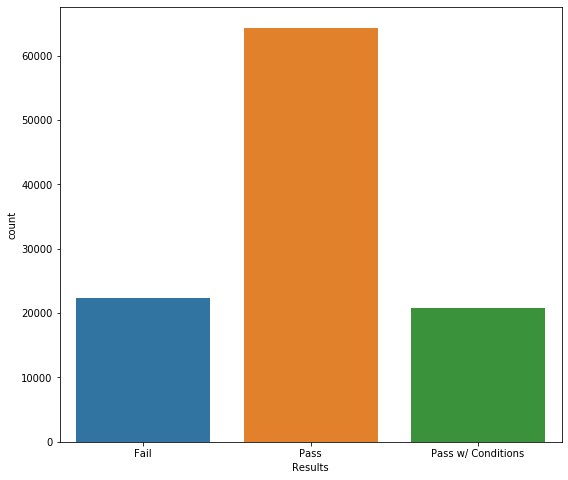

In [19]:
plt.figure(figsize=(9, 8))
sns.countplot(df2.Results)

### Data Analysis

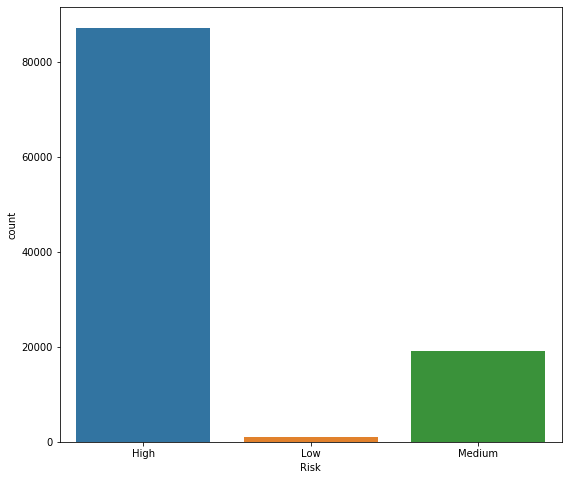

In [20]:
plt.figure(figsize=(9, 8))
sns.countplot(df2.Risk)

### Top 10 food chains with highest inspection failure

In [21]:
df_fail = df2[df2.Results.isin(["Fail"])]
Fail = pd.DataFrame(df_fail.groupby('DBA Name')['Results'].count())
Fail.rename(columns={"Results": "Failure Count"}, inplace=True)
Fail = Fail.sort_values(by ='Failure Count', ascending=False )
Fail.head(10)

,Failure Count
DBA Name,
SUBWAY,315
DUNKIN DONUTS,191
MCDONALD'S,88
MCDONALDS,53
POTBELLY SANDWICH WORKS LLC,50
HAROLD'S CHICKEN SHACK,41
DUNKIN DONUTS/BASKIN ROBBINS,40
CHIPOTLE MEXICAN GRILL,40
LAS ISLAS MARIAS,38


### Top 10 food chains with highest Violation count

In [22]:
Violation = pd.DataFrame(df2.groupby('DBA Name')['No. of Violations'].count())
Violation.rename(columns={"No. of Violations": "Violation Count"}, inplace=True)
Violation = Violation.sort_values(by ='Violation Count', ascending=False )
Violation.head(10)

,Violation Count
DBA Name,
SUBWAY,2364
DUNKIN DONUTS,1231
MCDONALD'S,460
CHIPOTLE MEXICAN GRILL,290
MCDONALDS,269
POTBELLY SANDWICH WORKS LLC,254
POTBELLY SANDWICH WORKS,225
CORNER BAKERY CAFE,219
DUNKIN DONUTS/BASKIN ROBBINS,207


### Top 10 Zip with highest Violation count

In [23]:
Zip = pd.DataFrame(df2.groupby('Zip')['No. of Violations'].count())
Zip.rename(columns={"No. of Violations": "Violation Count"}, inplace=True)
Zip = Zip.sort_values(by ='Violation Count', ascending=False )
Zip.head(10)

,Violation Count
Zip,
60611.0,4794
60614.0,4697
60657.0,4404
60647.0,4070
60622.0,3612
60607.0,3610
60654.0,3386
60618.0,3126
60640.0,3081


### Top 10 Zip with highest Complaints

In [24]:
complaint = pd.DataFrame(df2.groupby('Zip')['complaint'].count())
complaint.rename(columns={"complaint": "Complaint Count"}, inplace=True)
complaint = complaint.sort_values(by ='Complaint Count', ascending=False )
complaint.head(10)

,Complaint Count
Zip,
60611.0,4794
60614.0,4697
60657.0,4404
60647.0,4070
60622.0,3612
60607.0,3610
60654.0,3386
60618.0,3126
60640.0,3081


### Modeling

In [25]:
df2.columns

Index(['DBA Name', 'AKA Name', 'license', 'Facility Type', 'Risk', 'Address',
       'City', 'State', 'Zip', 'Inspection Date', 'Inspection Type', 'Results',
       'Violations_x', 'Latitude', 'Longitude', 'Location', 'y', 'complaint',
       'reinspection', 'index', 'Violations_y', 'No. of Violations'],
      dtype='object')

In [26]:
X = df2[['Risk', 'complaint', 'reinspection','No. of Violations']]
y = df2[['y']]

In [27]:
# generate binary values using get_dummies
X = pd.get_dummies(X, columns=["Risk"], prefix=["Risk_"] )
X

,complaint,reinspection,No. of Violations,Risk__High,Risk__Low,Risk__Medium
1,1,1,15,1,0,0
2,0,0,8,1,0,0
3,0,0,12,1,0,0
4,0,1,5,1,0,0
5,1,0,16,1,0,0
...,...,...,...,...,...,...
107491,0,1,0,1,0,0
107492,0,0,0,0,0,1
107493,1,0,3,0,0,1
107494,0,0,2,0,0,1


In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.2)

In [29]:
rf = RandomForestClassifier(n_estimators=1000,
                           criterion='entropy',
                           max_features=2,
                           n_jobs=-1,
                           class_weight='balanced')

In [30]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features=2,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Feature Importance

In [31]:
importances = list(zip(rf.feature_importances_, X.columns))
importances.sort(reverse=True)
importances

[(0.7850866154575782, 'No. of Violations'),
 (0.1958055078121079, 'reinspection'),
 (0.009897199977513363, 'complaint'),
 (0.0033458710500184, 'Risk__Low'),
 (0.0030304974703297123, 'Risk__High'),
 (0.002834308232452419, 'Risk__Medium')]

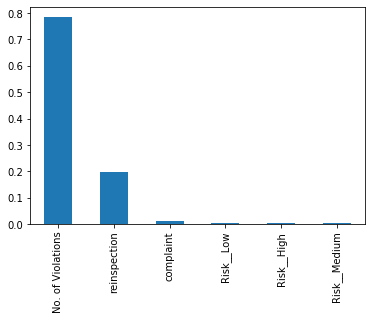

In [32]:
# Plotting feature importance
pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar', legend = False)

We can see above feature importance plot and number of violation follows by reinspection and complaints are top three important feature to explain out model

In [33]:
y_pred = rf.predict(X_test)

In [34]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6856597981301455


### Exporting results to CSV file

In [37]:
result = pd.DataFrame(y_pred)
result.index = X_test.index # for comparison later
result.columns = ["prediction"]
result.to_csv("inspectionprediction.csv")

### Saving Model to a Pickle

In [38]:
import pickle
filename = 'model.sav'
pickle.dump(rf, open(filename, 'wb'))

### Thought process

#### How you decide to define the target variable for your model 
I generated target variable by using result column. For my primary analysis I only considered the cases where the results are fail , pass or pass with condition in the result column and then I created a target variable y using condition where the result is fail its 1 else 0.

#### How you approach training, validation, test, and prediction
I divided the data into 80:20 ratio for train and test datasets

#### What features you explore
I have created a violation count features from violations and violation_y feature which only consider the voilation id. to further analyze this I found violation couont for SUBWAY, DUNKIN DONUTS, MCDONALD'S, CHIPOTLE MEXICAN GRILL is highest and on further analysis I found that these are the same food chain with highest number of failed inspection results.

I also have created a feature complaint and reinspection variables.

#### How you assess your features and their impact on you predictions

I have plotted random forest feature importance barplot


#### How you assess model performance
I have used accuracy metric to assess model perfromance


#### Scope which could not be implemented in this Notebook

- We can use natural language processing to find the keywords for major violations and then use dimentionality reduction techniques(PCA) to identify most important keywords.

- We can plot the inspection failure restaurant zip code wise on the map and see which area in the city of chicago has more failures visually

- We can consider more than just two class for target variable ( now it's fail or pass)


<p>